## 03_TPF_Statistics

In diesem Jupyter Notebook werden Statistiken und Visualisierungen aus Daten der Punktwolken und der Metashape Reports generiert. 
Die Daten basieren auf Bilder der DJI Mini 3 Pro von den folgenden Aufnahmetagen:
11.03.2025 und
19.03.2025

### Import der Libraries

In [1]:
import pandas as pd
import glob
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import laspy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import traceback

### Definition der Grundlagedaten

In [3]:
# CSV-Verzeichnis
csv_dir = "C:\\_Data\\BTh11\\BTh11_Trieblaengenwachstum\\03_TPF_Statistics\\03_BaseData"
print("Daten in CSV-Verzeichnis:", os.listdir(csv_dir))

# PointCloud-Verzeichnis
pc_dir = "F:\\530_PointClouds_TPF"
print("Daten in PointCloud-Verzeichnis:", os.listdir(pc_dir))



Daten in CSV-Verzeichnis: ['MetashapeReportData_20250311_DJIMini3Pro_Kirsche.csv', 'MetashapeReportData_20250319_DJIMini3Pro_Kirsche.csv', 'old']
Daten in PointCloud-Verzeichnis: ['20250311_DJIMini3Pro_Kirsche_TiePointFiltering_100.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_20.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_40.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_60.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_80.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_90.las']


### Import der CSV-Daten

In [4]:
# Laden aller CSV-Dateien MetashapeReportData_<ID>.csv finden
csv_files = glob.glob(os.path.join(csv_dir, "MetashapeReportData_*.csv"))

# Alle CSVs einlesen und in einer Liste speichern
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Alle DataFrames zusammenfügen
combined_df = pd.concat(df_list, ignore_index=True)

# Vorschau
display(HTML(combined_df.head(10).to_html(max_cols=200, notebook=True)))

,Aufnahme_ID,TPF,Anzahl_Ringe,Nadir,Anzahl_Bilder,Format,Windboehen,ImageAlignement_Accuracy,Key_Point_Limit,Tie_Point_Limit,Excl_Stationary_Tie_Pts,Guided_Img_Matching,Adaptive_Model_Fitting,Start_Points,Automatic_Filtering,Manual_Filtering,Reprojection_Error,Reconstruction_Uncertainty,Image_Count,Projection_Accuracy,Automatic_Detection,GCP_Accuracy_m,XY_Error_mm,Z_Error_mm,Total_Error_mm,Error_pix,Metashape_Report,Source_Data,PointCloud_Quality,Depth_Filtering,Point_Colors,Point_Confidence,Points_Total,Points_Tree
0,20250311_DJIMini3Pro_Kirsche,100%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,319000,NaN,NaN,NaN,NaN,True,0.01,9.42,3.69,10.12,3.89,True,DM,U-High,Mild,True,True,378.0,NaN
1,20250311_DJIMini3Pro_Kirsche,90%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,287000,NaN,52.0,NaN,24.0,True,0.01,10.41,3.72,11.06,3.52,True,DM,U-High,Mild,True,True,377.0,NaN
2,20250311_DJIMini3Pro_Kirsche,80%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,256000,NaN,37.0,NaN,10.0,True,0.01,9.33,3.55,9.98,4.05,True,DM,U-High,Mild,True,True,375.0,NaN
3,20250311_DJIMini3Pro_Kirsche,70%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,223000,NaN,29.0,NaN,7.0,True,0.01,10.95,3.55,11.51,3.45,True,DM,U-High,Mild,True,True,374.0,NaN
4,20250311_DJIMini3Pro_Kirsche,60%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,194000,NaN,24.0,NaN,8.0,True,0.01,9.69,3.36,10.25,4.07,True,DM,U-High,Mild,True,True,373.0,NaN
5,20250311_DJIMini3Pro_Kirsche,40%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,128000,NaN,18.0,NaN,7.0,True,0.01,9.65,3.46,10.25,4.11,True,DM,U-High,Mild,True,True,364.0,NaN
6,20250311_DJIMini3Pro_Kirsche,20%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,64000,NaN,12.0,NaN,6.0,True,0.01,9.92,3.70,10.58,4.12,True,DM,U-High,Mild,True,True,347.0,NaN
7,20250319_DJIMini3Pro_Kirsche,100%,7.0,True,500.0,H,False,Highest,60000,0,True,False,True,1188000,867000,867000,NaN,NaN,NaN,NaN,True,0.01,7.54,4.56,8.81,2.49,True,DM,U-High,Mild,True,True,452.0,NaN
8,20250319_DJIMini3Pro_Kirsche,90%,7.0,True,500.0,H,False,Highest,60000,0,True,False,True,1188000,867000,781000,NaN,NaN,NaN,23.0,True,0.01,7.35,4.71,8.73,2.51,True,DM,U-High,Mild,True,True,453.0,NaN
9,20250319_DJIMini3Pro_Kirsche,80%,7.0,True,500.0,H,False,Highest,60000,0,True,False,True,1188000,867000,694000,NaN,NaN,NaN,27.0,True,0.01,7.30,4.64,8.65,2.50,True,DM,U-High,Mild,True,True,457.0,NaN


### Vergleich Root Mean Square Error (RMSE) pro Tie Point Filtering (TPF) Kategorie

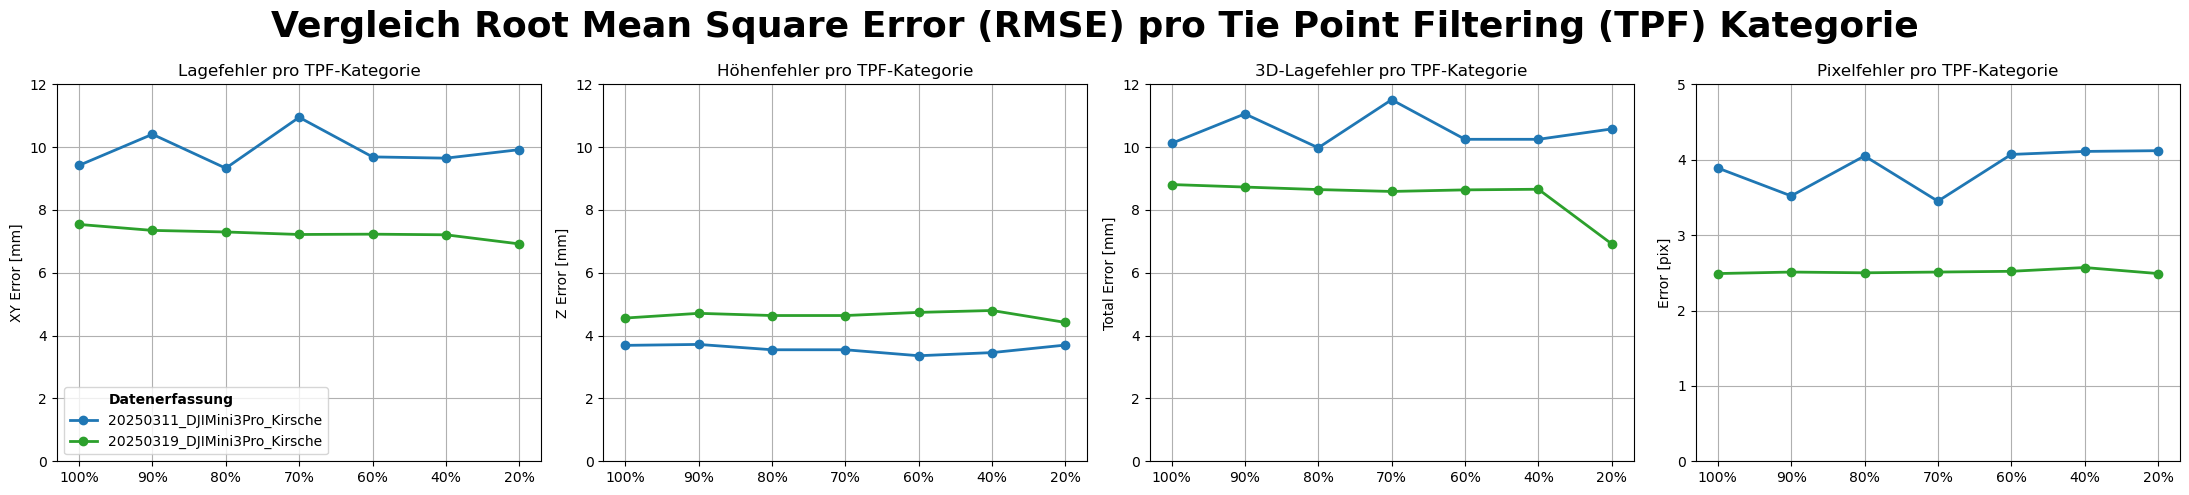

In [68]:
# TPF-Werte als Kategorien
combined_df["TPF"] = pd.Categorical(
    combined_df["TPF"],
    categories=["100%", "90%", "80%", "70%", "60%", "40%", "20%"],
    ordered=True
)

# Attributnamen + Titel + y-Achsenbeschriftung + Achsenskalierung
attributes = [
    ("XY_Error_mm", "Lagefehler pro TPF-Kategorie", "XY Error [mm]", (0, 12)),
    ("Z_Error_mm", "Höhenfehler pro TPF-Kategorie", "Z Error [mm]", (0, 12)),
    ("Total_Error_mm", "3D-Lagefehler pro TPF-Kategorie", "Total Error [mm]", (0, 12)),
    ("Error_pix", "Pixelfehler pro TPF-Kategorie", "Error [pix]", (0, 5)),
]

# Farbzuweisung für Aufnahme_IDs
aufnahme_colors = {
    "20250311_DJIMini3Pro_Kirsche": "#1f77b4",        # Blau
    "20250319_DJIMini3Pro_Kirsche": "#2ca02c",        # Grün
    # Platzhalter für weitere IDs
}

# Subplots
fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharex=True)

for ax, (attr, title, ylabel, ylim) in zip(axes, attributes):
    for aufnahme_id, group in combined_df.groupby("Aufnahme_ID"):
        group_sorted = group.sort_values("TPF")
        ax.plot(
            group_sorted["TPF"],
            group_sorted[attr],
            label=aufnahme_id,
            marker="o",
            linewidth=2,
            color=aufnahme_colors[aufnahme_id]
        )
    ax.set_title(title)
    ax.set_ylim(*ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Verwendeter Anteil an Tie Points [%]")
    ax.grid(True)

# Titel für alle Plots
fig.suptitle(
    "Vergleich Root Mean Square Error (RMSE) pro Tie Point Filtering (TPF) Kategorie",
    fontsize=26,
    fontweight="bold"
)

# Platzierung der Legende 
handles, labels = axes[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color='none')] + handles
labels = ["Datenerfassung"] + labels
legend = axes[0].legend(handles, labels, loc="lower left", frameon=True)

# Stil der Legende
legend.get_texts()[0].set_weight("bold")     
legend.get_texts()[0].set_fontsize("medium")

plt.tight_layout()
plt.show()

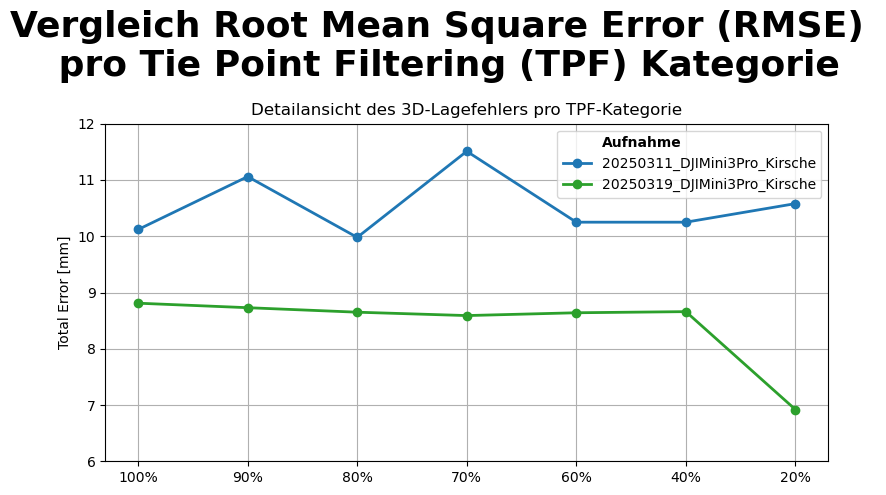

In [69]:
# DETAILPLOT für Total_Error_mm
fig, ax = plt.subplots(figsize=(8, 5))

for aufnahme_id, group in combined_df.groupby("Aufnahme_ID"):
    group_sorted = group.sort_values("TPF")
    ax.plot(
        group_sorted["TPF"],
        group_sorted["Total_Error_mm"],
        label=aufnahme_id,
        marker="o",
        linewidth=2,
        color=aufnahme_colors.get(aufnahme_id, "grey")
    )

ax.set_title("Detailansicht des 3D-Lagefehlers pro TPF-Kategorie")
ax.set_ylabel("Total Error [mm]")
ax.set_xlabel("Verwendeter Anteil an TIe Points [%]")
ax.set_ylim(6, 12)
ax.grid(True)

# Gemeinsamer Titel für alle Plots
fig.suptitle(
    "Vergleich Root Mean Square Error (RMSE) \n pro Tie Point Filtering (TPF) Kategorie",
    fontsize=26,
    fontweight="bold"
)

# Legende unten links mit Titel als Dummy-Zeile (Workaround)
handles, labels = ax.get_legend_handles_labels()
handles = [plt.Line2D([], [], color='none')] + handles
labels = ["Aufnahme"] + labels
legend = ax.legend(handles, labels, loc="upper right", frameon=True)
legend.get_texts()[0].set_weight("bold")
legend.get_texts()[0].set_fontsize("medium")

plt.tight_layout()
plt.show()

### Histogramm der Confidence-Werte der Punktwolken in Kategorien

pc_dir: F:\530_PointClouds_TPF


Lese LAS-Dateien:   0%|          | 0/6 [00:00<?, ?it/s]

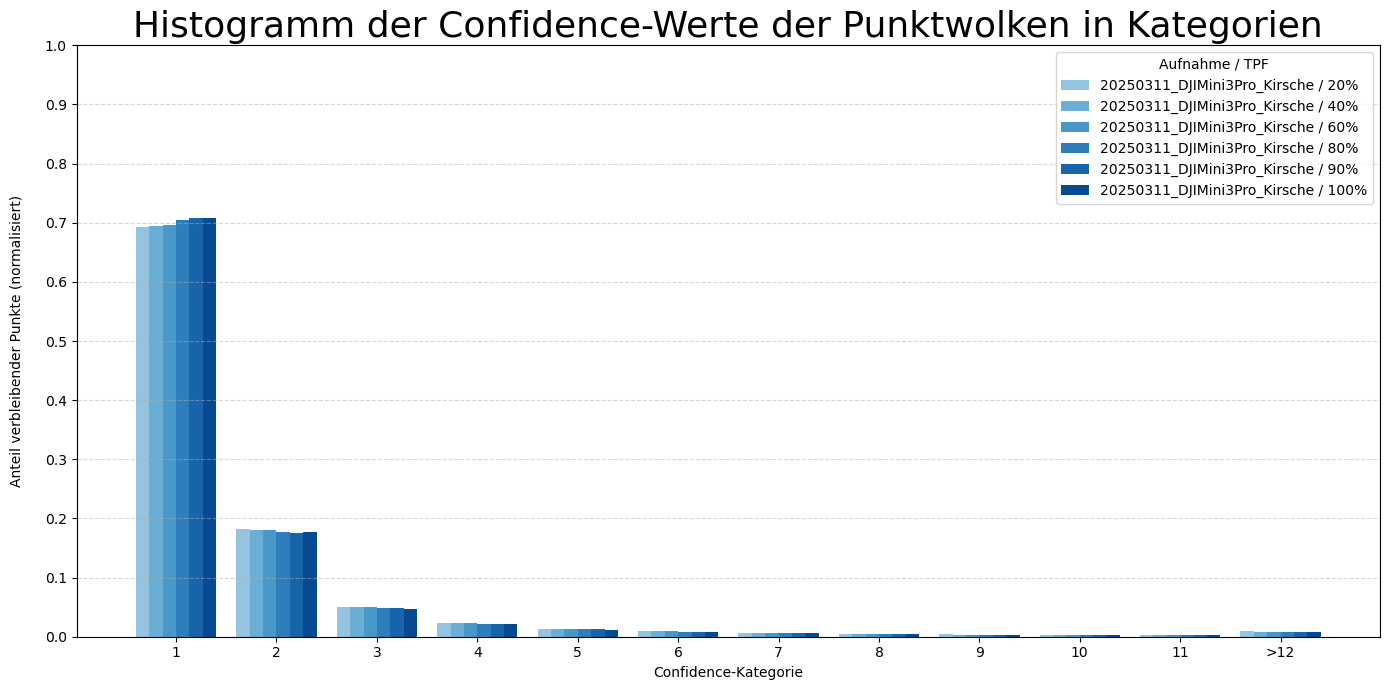

In [10]:
# Verzeichnis prüfen
print("pc_dir:", pc_dir)
if not os.path.exists(pc_dir):
    raise FileNotFoundError(f"Verzeichnis nicht gefunden: {pc_dir}")

# Bins: 1–12, letzte Kategorie >12
bins = list(np.arange(1, 13)) + [np.inf]
bin_labels = [str(i) for i in range(1, 12)] + [">12"]

# Initialisierung
results = {}
tpf_set = set()
aufnahme_set = set()

# LAS-Dateien erkennen
las_files = sorted([
    f for f in os.listdir(pc_dir)
    if f.endswith(".las") and "_TiePointFiltering_" in f
])

if not las_files:
    raise FileNotFoundError("Keine passenden .las-Dateien gefunden.")

# Punktwolken einlesen
for fname in tqdm(las_files, desc="Lese LAS-Dateien"):
    try:
        match = re.match(r"(.+)_TiePointFiltering_(\d+)\.las", fname)
        if not match:
            print(f"Übersprungen: {fname}")
            continue

        aufnahme_id, tpf = match.groups()
        tpf_label = f"{tpf}%"
        key = (aufnahme_id, tpf_label)

        path = os.path.join(pc_dir, fname)
        las = laspy.read(path)

        if "confidence" not in las.point_format.dimension_names:
            print(f"Feld 'confidence' fehlt in Datei: {fname}")
            continue

        confidence = las['confidence']
        counts = np.histogram(confidence, bins=bins)[0]

        if len(counts) != len(bin_labels):
            min_len = min(len(counts), len(bin_labels))
            counts = counts[:min_len]
            bin_labels = bin_labels[:min_len]

        total = np.sum(counts)
        norm_counts = counts / total if total > 0 else np.zeros_like(counts)

        results[key] = norm_counts
        tpf_set.add(int(tpf))
        aufnahme_set.add(aufnahme_id)

    except Exception as e:
        print(f"Fehler bei Datei {fname}:")
        traceback.print_exc()

# Sortieren
tpf_values = sorted(tpf_set, reverse=True)
aufnahme_ids = sorted(aufnahme_set)

# Abgestufte Farben: helles Blau → mittleres Blau (nicht ganz bis dunkel)
blues = plt.colormaps["Blues"]
n = len(tpf_values)
tpf_colors = {
    f"{tpf}%": blues(0.4 + 0.5 * i / max(n - 1, 1)) for i, tpf in enumerate(sorted(tpf_values))
}

# Plot vorbereiten
x = np.arange(len(bin_labels))
width = 0.8 / len(tpf_values)

fig, ax = plt.subplots(figsize=(14, 7))

for i, tpf in enumerate(sorted(tpf_values)):
    tpf_label = f"{tpf}%"
    for aufnahme_id in aufnahme_ids:
        key = (aufnahme_id, tpf_label)
        if key not in results:
            continue
        offset = x + i * width - (width * (len(tpf_values) - 1) / 2)
        heights = results[key]
        label = f"{aufnahme_id} / {tpf_label}"
        ax.bar(offset, heights, width=width, label=label, color=tpf_colors[tpf_label])

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(bin_labels, rotation=0)
ax.set_xlabel("Confidence-Kategorie")
ax.set_ylabel("Anteil verbleibender Punkte (normalisiert)", rotation=90, labelpad=15)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title("Histogramm der Confidence-Werte der Punktwolken in Kategorien", fontsize=26)
ax.legend(title="Aufnahme / TPF", loc="upper right", frameon=True)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()